In [1]:
import os

import gym
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy

from apmd_on.apmd import PMD

plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2

/Users/patrick/miniforge3/envs/irl/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [4]:
n_episodes = int(2e7/500)

def smooth(scalars, weight: float):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

def plot_costs_with_band(rewards, names, smoothing_window=10, n=3, fig_name="acrobot.png", stds=None):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(1,1,figsize=(7, 5))
    for i in range(n):
        extend = np.concatenate([np.ones(smoothing_window)*rewards[i][0], rewards[i]])
        rewards_smoothed = pd.Series(extend).rolling(smoothing_window, min_periods=smoothing_window).mean().to_numpy()
        rewards_smoothed = rewards_smoothed[smoothing_window:]
        # rewards_smoothed = rewards_smoothed[:1000]
        x = np.linspace(0, 3e7, num=rewards_smoothed.shape[0])
        # print(x.shape, rewards_smoothed.shape)
        if stds is None:
            ax.plot(x, rewards_smoothed, label=names[i], linewidth=3)
        else:
            std_smoothing_window = 1
            lower = rewards_smoothed - stds[i] * 0.95
            upper = rewards_smoothed + stds[i] * 0.95

            lower_extend = np.concatenate([np.ones(std_smoothing_window)*lower[0], lower])
            upper_extend = np.concatenate([np.ones(std_smoothing_window)*upper[0], upper])
            lower_smoothed = pd.Series(lower_extend).rolling(std_smoothing_window, min_periods=std_smoothing_window).mean().to_numpy()[std_smoothing_window:]
            upper_smoothed = pd.Series(upper_extend).rolling(std_smoothing_window, min_periods=std_smoothing_window).mean().to_numpy()[std_smoothing_window:]

            ax.plot(x, rewards_smoothed, label=names[i], linewidth=3)
            ax.fill_between(x, y1=lower_smoothed, y2=upper_smoothed, interpolate=False, alpha=0.5)

    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel("Timesteps")
    plt.ylabel("Mean Episodic Reward")
    plt.title(fig_name)
    plt.legend()
    plt.show()

In [9]:
# off-policy pmd
env_id = 'Hopper-v4'
evaluation = np.load(f'/Users/patrick/Developer/Inverse-Policy-Mirror-Descent/logs/iapmd/10traj/Humanoid-v4-2022-11-06 22:02:29/evaluations.npz')
epsodic_rewards = evaluation['results']
mean = epsodic_rewards.mean(axis=1)
std = epsodic_rewards.std(axis=1)
# plot_costs_with_band([mean], names=['MDPO'], smoothing_window=10, n=1, fig_name=env_id, stds=std)
epsodic_rewards = evaluation['results']
mean = epsodic_rewards.mean(axis=1)
print(epsodic_rewards.max())

7722.073666


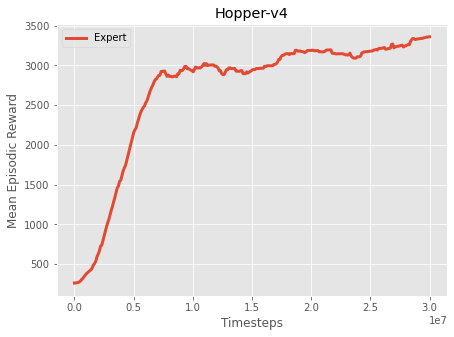

In [29]:
# off-policy pmd
env_id = 'Hopper-v4'
evaluation = np.load(f'utils/logs/{env_id}/results/evaluations.npz')
epsodic_rewards = evaluation['results']
mean = epsodic_rewards.mean(axis=1)
std = epsodic_rewards.std(axis=1)
plot_costs_with_band([mean], names=['Expert'], smoothing_window=50, n=1, fig_name=env_id, stds=std)

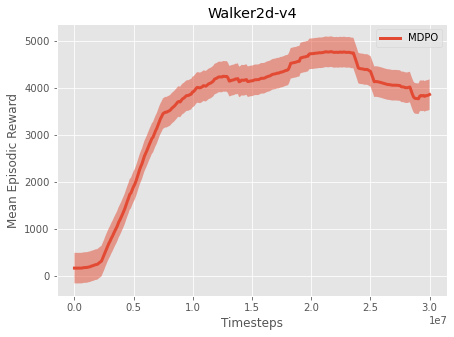

In [24]:
# off-policy pmd
env_id = 'Walker2d-v4'
evaluation = np.load(f'logs/{env_id}-iapmd-oct3/evaluations.npz')
epsodic_rewards = evaluation['results']
mean = epsodic_rewards.mean(axis=1)
std = epsodic_rewards.std(axis=1)
plot_costs_with_band([mean], names=['MDPO'], smoothing_window=50, n=1, fig_name=env_id, stds=std)

In [15]:
import gym
import numpy as np

from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env



model = SAC.load("/Users/patrick/Developer/Inverse-Policy-Mirror-Descent/utils/logs/expert/Walker2d-v4-sac/model5e6.zip")

for env in ['Ant-v4', 'HalfCheetah-v4', 'Hopper-v4','Humanoid-v4','Walker2d-v4']:
    model_path = f'/Users/patrick/Developer/Inverse-Policy-Mirror-Descent/utils/logs/expert/{env}-sac/model5e6.zip'
    model = SAC.load(model_path)
    traj = evaluate_policy(model, make_vec_env(env) )
    print(f'{env}: {np.mean(traj)} +- {np.std(traj)}, {traj}')

Ant-v4: 2944.7465602550697 +- 2838.8806987449293, (5783.627258999999, 105.86586151014004)
HalfCheetah-v4: 7752.640863763697 +- 7714.922654936304, (15467.5635187, 37.718208827393276)
Hopper-v4: 2065.6893769712206 +- 2049.839772928779, (4115.5291498999995, 15.84960404244114)


/Users/patrick/miniforge3/envs/irl/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 6.09GB > 3.99GB
  warnings.warn(


Humanoid-v4: 3583.8356659241326 +- 3553.8727243758676, (7137.7083903, 29.962941548265015)
Walker2d-v4: 2673.9188612045828 +- 2649.8832781954184, (5323.802139400001, 24.035583009164405)
